<center>
## Открытый курс по машинному обучению. Сессия № 3

### <center> Автор материала: Краснов Дмитрий Анатольевич

## <center> Индивидуальный проект по анализу данных </center>

## <center> Прогнозирование рейтинга отеля </center>

In [2]:
import random
import re
from collections import Counter

import numpy as np
import pandas as pd

from scipy import stats
from scipy.sparse import csr_matrix, hstack

from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.feature_extraction.text import CountVectorizer
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(rc={'figure.figsize':(15,10)})
sns.set_style("darkgrid")
random.seed(42)

###  Часть 1. Описание набора данных и признаков

 В интернете существует множество различных сайтов с рейтингами и рекомендательных систем - что логично, ведь гораздо лучше узнать качество услуги/товара пользуясь чужими ошибками, а не своими. Например, планируя путешествие разумно будет изучить рейтинги отелей, чтобы не оказаться в ситуации когда отпуск будет испорчен ужасными условиями проживания. Такой рейтинг можно найти например на сайтах, которые предлагают услуги бронирования. И как можно догадаться, именно отзывы посетителей будут анализироваться в данном индивидуальном проекте - [Jason Liu](https://www.kaggle.com/jiashenliu/datasets) любезно выложил на kaggle датасет с отзывами. Этот набор данных содержит 515,000 оценок отзывов посетителей 1493 отелей в европе. Изначально данные получены путем скраппинга сайта booking.com, сам датасет был скачан [по этой ссылке](https://www.kaggle.com/jiashenliu/515k-hotel-reviews-data-in-europe).
 
В исходном файле содержатся 17 признаков - 

*   Hotel_Address: Адрес отеля
*   Review_Date: Дата написания отзыва
*   Average_Score: Средняя оценка отеля, рассчитанная на основе комментариев за прошлый год.
*   Hotel_Name: Название отеля
*   Reviewer_Nationality: Национальность посетителя
*   Negative_Review: Негативный отзыв, оставленный посетителем. Если автор не оставил негативный отзыв, значением будет 'No Negative'
*   Review_Total_Negative_Word_Counts: Количество слов в негативном отзыве.
*   Positive_Review: Положительный отзыв, оставленный посетителем. Если автор не оставил положительный отзыв, значением будет 'No Positive'
*   Review_Total_Positive_Word_Counts: Количество слов в позитивном отзыве.
*   Reviewer_Score: Оценка, которую автор дал посещенному отелю, основываясь на своем опыте.
*   Total_Number_of_Reviews_Reviewer_Has_Given: Число отзывов, которые автор оставлял ранее
*   Total_Number_of_Reviews: Число отзывов, оставленных отелю
*   Tags: Тэги проставленные отдыхающим
*   days_since_review: Количество дней которое прошло между датой отзыва и датой сбора данных
*   Additional_Number_of_Scoring: Некоторые люди не пишут отзыв, а просто ставят оценку. Данный параметр показывает сколько таких оценок (без сопутствующего отзыва) было проставленно отелю.
*   lat: Широта, на которой находится отель
*   lng: Долгота, на которой находится отель





Текст был очищен от знаков препинания и символов юникода, а так же приведен к нижнему регистру автором датасета.

При этом не все признаки будут использоваться в анализе - например, "days_since_review" абсолютно неинформативный признак, учитывая что у нас и так есть дата написания отзыва.

Целевым признаком очевидно будет оценка пользователем отеля - ее мы и будем предсказывать.
Ну что же - посмотрим, какие интересные закономерности мы найдем в процессе исследования датасета, а так же получится ли предсказать оценку которую посетитель оставит отелю.



###  Часть 2. Первичный анализ признаков

Загрузим данные и посмотрим на них

In [3]:
df = pd.read_csv('Hotel_Reviews.csv', parse_dates=['Review_Date'])
df = df.sort_values(by='Review_Date')
df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
113053,225 Edgware Road Westminster Borough London W2...,1485,2015-08-04,7.5,Hilton London Metropole,United Kingdom,First day the swimming pool was not opened th...,54,6977,The hotel was clean and accessible,8,4,7.5,"[' Leisure trip ', ' Group ', ' Superior Queen...",730 day,51.519569,-0.170521
239944,7 Rue des Petits H tels 10th arr 75010 Paris F...,125,2015-08-04,8.6,Hotel Mademoiselle,United Kingdom,No Negative,0,853,very good location breakfast was great,7,10,8.3,"[' Leisure trip ', ' Group ', ' Junior Suite '...",730 day,48.877249,2.354304
396823,Parkring 12a 01 Innere Stadt 1010 Vienna Austria,130,2015-08-04,8.2,Vienna Marriott Hotel,Qatar,Nothing,2,939,It was very nice excellent hotel,7,4,10.0,"[' Family with young children ', ' Executive D...",730 day,48.205097,16.377093
320201,Europaboulevard 10 Zuideramstel 1083 AD Amster...,341,2015-08-04,7.8,Novotel Amsterdam City,Austria,No Negative,0,2501,Slightly out of the city center but very easy...,27,34,9.6,"[' Leisure trip ', ' Group ', ' Standard Room ...",730 day,52.333803,4.888471
345928,Holland Park Avenue Kensington and Chelsea Lon...,843,2015-08-04,7.8,Hilton London Kensington Hotel,Qatar,No Negative,0,3801,Great easy to reAch location,6,5,7.5,"[' Leisure trip ', ' Solo traveler ', ' Double...",730 day,51.505108,-0.213266


In [4]:
df.describe(include = "all").T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Hotel_Address,515738,1493,163 Marsh Wall Docklands Tower Hamlets London ...,4789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Additional_Number_of_Scoring,515738,NaN,NaN,NaN,NaN,NaN,498.082,500.538,1,169,341,660,2682
Review_Date,515738,731,2017-08-02 00:00:00,2585,2015-08-04 00:00:00,2017-08-03 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Average_Score,515738,NaN,NaN,NaN,NaN,NaN,8.39749,0.548048,5.2,8.1,8.4,8.8,9.8
Hotel_Name,515738,1492,Britannia International Hotel Canary Wharf,4789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Reviewer_Nationality,515738,227,United Kingdom,245246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Negative_Review,515738,330011,No Negative,127890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Review_Total_Negative_Word_Counts,515738,NaN,NaN,NaN,NaN,NaN,18.5395,29.6908,0,2,9,23,408
Total_Number_of_Reviews,515738,NaN,NaN,NaN,NaN,NaN,2743.74,2317.46,43,1161,2134,3613,16670
Positive_Review,515738,412601,No Positive,35946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Как видим, пропусков почти нет, но все же удалим строки с незаполненными данными . Количество уникальных значений наименований отеля меньше на один, чем количство адресов - скорее всего какой то адрес был записан с ошибкой в одном из наблюдений, или потерялся символ при предобработке датасета. Данные получены в промежутке с 4 августа 2015 по 3 августа 2017. Средннее значение рейтинга отеля почти точно повторяет среднее пользовательских рейтингов, хотя и с меньшей дисперисией - что логично. Видны выбросы в параметре "количество оценок, оставленных посетителем" - при медиане в 3 кто-то сумел настрочить 395 отзывов. Впоследствии мы всех кто много путешествует (количество отзывов > 30) объединим в одну группу.

In [5]:
df = df.dropna()
df.shape

(512470, 17)


Выделим численные признаки и посмотрим, как они связаны между собой.

In [6]:
numeric_cols = [
    'Additional_Number_of_Scoring',
    'Average_Score',
    'Review_Total_Negative_Word_Counts',
    'Total_Number_of_Reviews',
    'Review_Total_Positive_Word_Counts',
    'Total_Number_of_Reviews_Reviewer_Has_Given',
    'Reviewer_Score',
    'lat',
    'lng'
]
corr_data = df[numeric_cols].corr()
corr_data

,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,lat,lng
Additional_Number_of_Scoring,1.000000,-0.153779,0.029226,0.825215,-0.052953,-0.071664,-0.061973,0.336295,-0.295732
Average_Score,-0.153779,1.000000,-0.112634,-0.180101,0.106992,0.036870,0.364967,-0.108642,0.106078
Review_Total_Negative_Word_Counts,0.029226,-0.112634,1.000000,0.035158,0.119116,0.003019,-0.382574,0.019112,-0.020002
Total_Number_of_Reviews,0.825215,-0.180101,0.035158,1.000000,-0.029974,-0.024983,-0.073081,0.100295,-0.014141
Review_Total_Positive_Word_Counts,-0.052953,0.106992,0.119116,-0.029974,1.000000,0.026451,0.220734,-0.037567,0.035471
Total_Number_of_Reviews_Reviewer_Has_Given,-0.071664,0.036870,0.003019,-0.024983,0.026451,1.000000,0.002985,-0.059793,0.110810
Reviewer_Score,-0.061973,0.364967,-0.382574,-0.073081,0.220734,0.002985,1.000000,-0.036562,0.034001
lat,0.336295,-0.108642,0.019112,0.100295,-0.037567,-0.059793,-0.036562,1.000000,-0.304524
lng,-0.295732,0.106078,-0.020002,-0.014141,0.035471,0.110810,0.034001,-0.304524,1.000000


Как видим, между данными нет сильной корреляции - только между количеством отзывов и количеством оценок без отзывов, что вполне логично - чем популярнее отель, тем больше отзывов и оценок оставляют о нем.

Выделим целевой прзнак и проведем статтесты на нормальность и скошенность

In [7]:
y = df['Reviewer_Score']
y.describe()

count    512470.000000
mean          8.395594
std           1.638170
min           2.500000
25%           7.500000
50%           8.800000
75%           9.600000
max          10.000000
Name: Reviewer_Score, dtype: float64

In [8]:
print(stats.normaltest(y))
print(stats.skew(y))

NormaltestResult(statistic=87916.84221853649, pvalue=0.0)
-1.1937089053972578


Как мы видим, гипотеза о нормальности отвергается, распеределение имеет левостороннюю ассиметрию - ну это было ясно из среднего в 8.4. Такие значения соответсвуют интуитивному представлению о том, как люди распределяют оценки - редко какие оценки (от школьных до различных рейтингов) распределяются равномерно, почти всегда они распределены вокруг оценки "хорошо" - ну или вокруг оценки "плохо" если это антирейтинг (например, сайт с плохими отзывами о работодателях). Попробуем получить больше информации с помощью визуализаций.

###  Часть 3. Первичный визуальный анализ признаков

Начнем с того, что построим графики распределений оценок

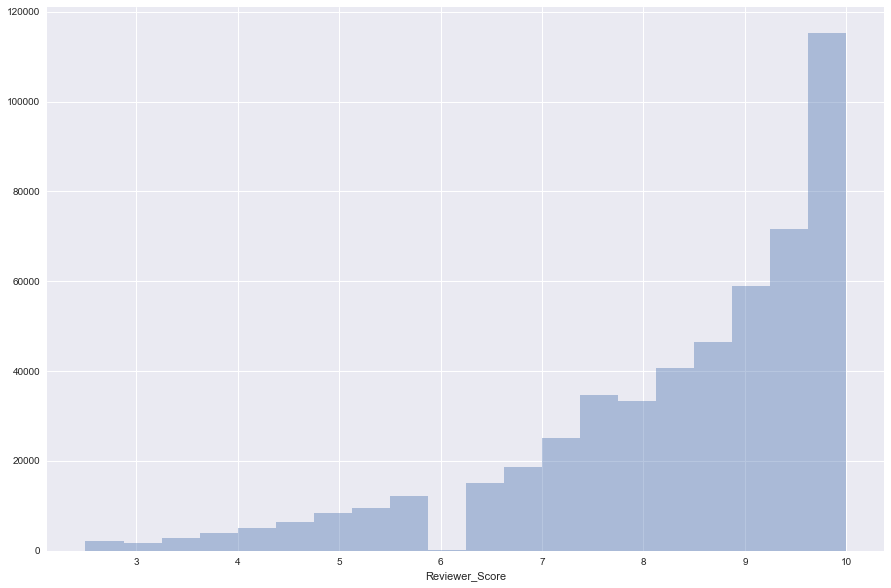

In [9]:

sns.distplot(y,kde=False, bins=20);

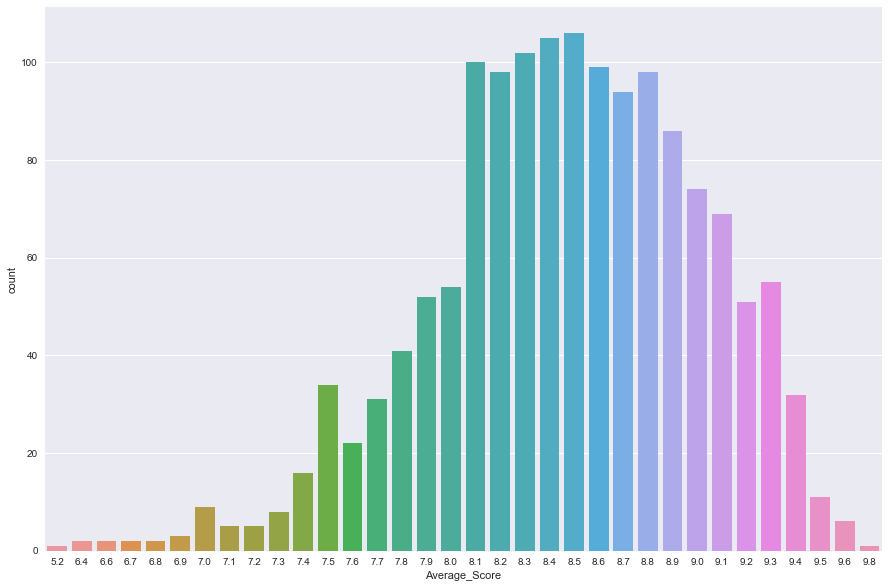

In [10]:
data_plot = df[["Hotel_Name","Average_Score"]].drop_duplicates()

sns.countplot(x='Average_Score',data=data_plot)

Как видим, люди склонны ставить максимальные оценки отелям после посещений. Из графика мы можем явно убедиться, что распеределение не  является нормальным. В тоже время распределине средних оценок отелей уже гораздо более похоже на нормальное - центральная предельная теорема в деле. 
Визуализурием матрицу корреляций.

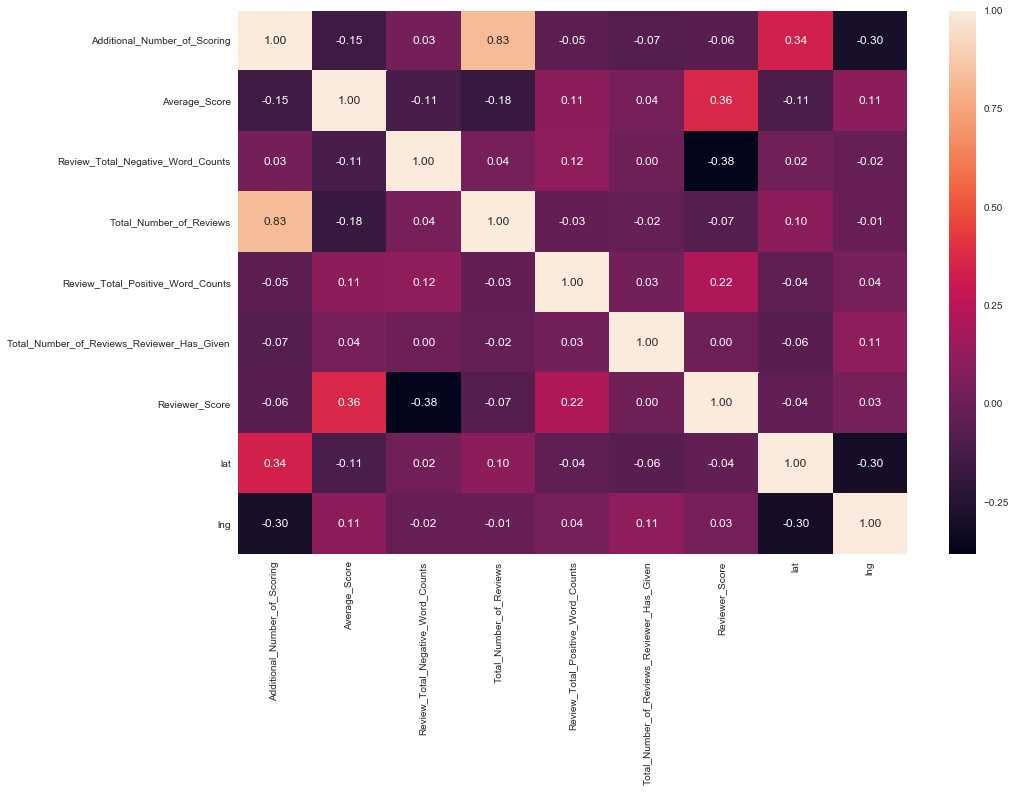

In [11]:
sns.heatmap(corr_data, annot=True, fmt = '.2f')

Никакой новой информации по сравнению с табличным представлением на мой взгляд не появилось. Разве что стало хорошо видно, что единстванная переменная которая значимо коррелирует с целевой - это средний рейтинг отеля, что думаю вполне очиведно.  
Посмотрим, как менялись оценки людей со временем.

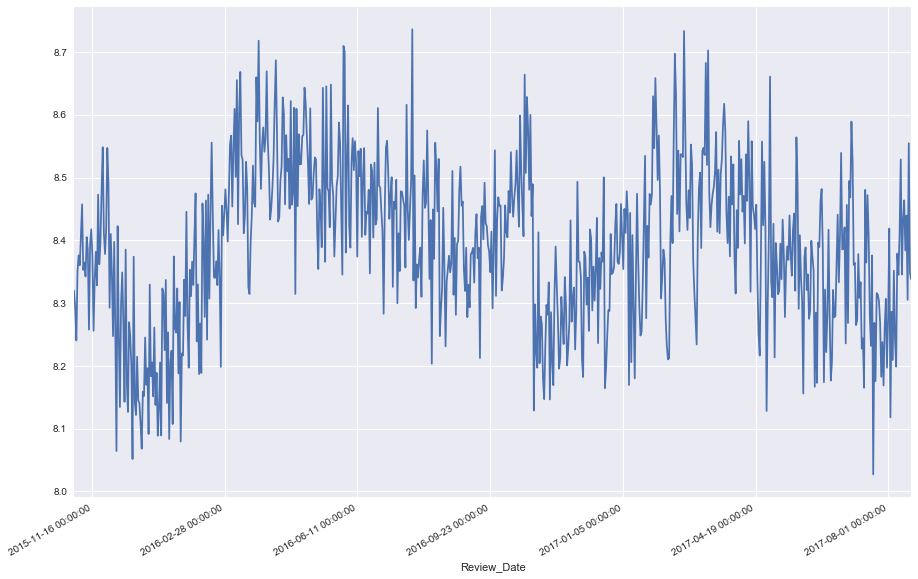

In [12]:
time_data = df.groupby("Review_Date")["Reviewer_Score"].mean().sort_index()
fig, ax = plt.subplots()
sns.tsplot(time=time_data.index, data=time_data.values, ax=ax)
ax.set_xticklabels(time_data.index[::104])
fig.autofmt_xdate()
plt.show()

На общем графике видна сезонность по месяцам, по годам рейтинги выглядят похожими. Проверим это, взглянув на распределение по годам и месяцам. Будем строить отчитывать график не с нуля, а с 7 - чтобы было лучше видно разницу 

In [13]:
df['year'] = df['Review_Date'].dt.year
df['month'] = df['Review_Date'].dt.month

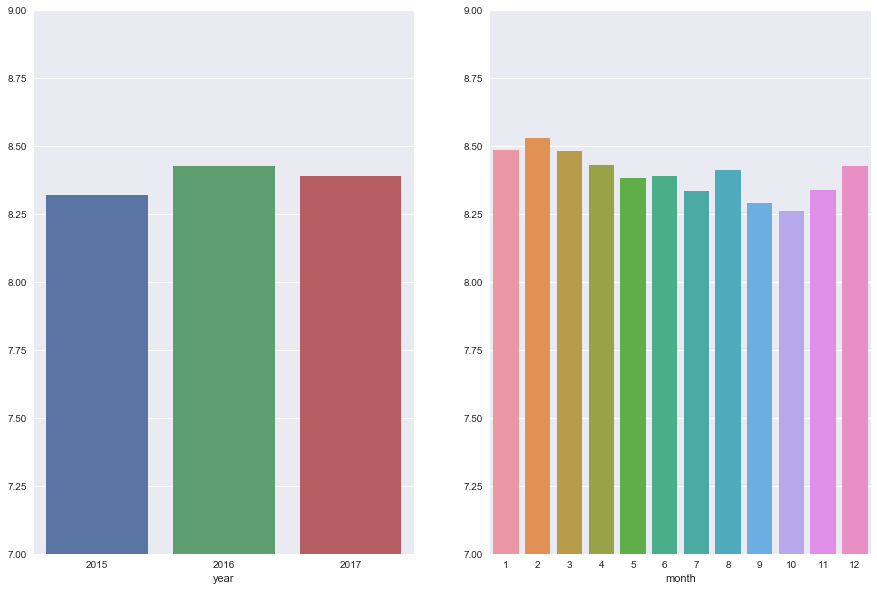

In [14]:
month_hist = df.groupby("month")['Reviewer_Score'].mean().sort_index()
year_hist = df.groupby("year")['Reviewer_Score'].mean().sort_index()

fig, axs = plt.subplots(ncols=2)
axs[0].set_ylim(7,9)
axs[1].set_ylim(7,9)

sns.barplot(x=year_hist.index, y=year_hist.values, ax=axs[0])
sns.barplot(x=month_hist.index, y=month_hist.values, ax=axs[1])

Как видно, колебания небольшие, при этом от года к году они особенно малы. 

Посмотрим на текстовые данные. Визуализировать их будем при помощи облака тегов - может найдет что-нибудь интересное

In [15]:
from wordcloud import WordCloud
wc_params = {'background_color': 'white', 'width': 600, 'height': 300, 'max_font_size': 300, 'max_words': 40}

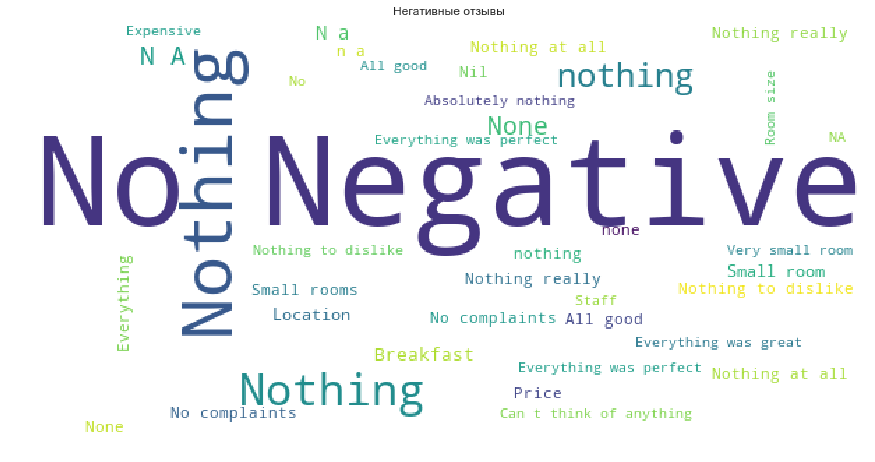

In [16]:
wordcloud = WordCloud(**wc_params).generate_from_frequencies(df['Negative_Review'].value_counts())
plt.imshow(wordcloud)
plt.title("Негативные отзывы")
plt.axis("off")
plt.show()

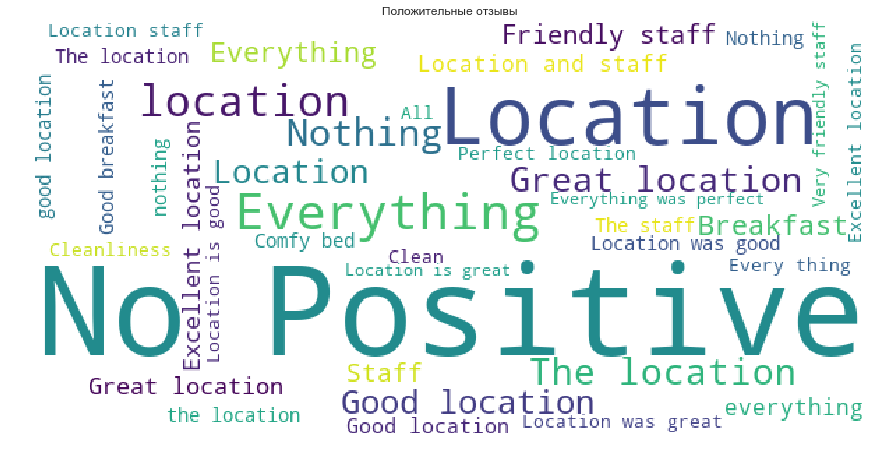

In [17]:
wordcloud = WordCloud(**wc_params).generate_from_frequencies(df['Positive_Review'].value_counts())
plt.imshow(wordcloud)
plt.title("Положительные отзывы")
plt.axis("off")
plt.show()

Удивительно, но большинство негативных отзывов - это слова о том что все хорошо) Больше всего люди жалуются на маленьке комнаты и дороговизну. Ценят же само место, персонал, чистоту и завтраки. Посмотрим, найдется ли что-либо интересное в тегах. 

Сначала вырежем лишние символы из тегов

In [18]:
df['clean_tags'] = df['Tags'].apply(lambda x: ', '.join([s[2:-2] for s in x[1:-1].split(', ')]))

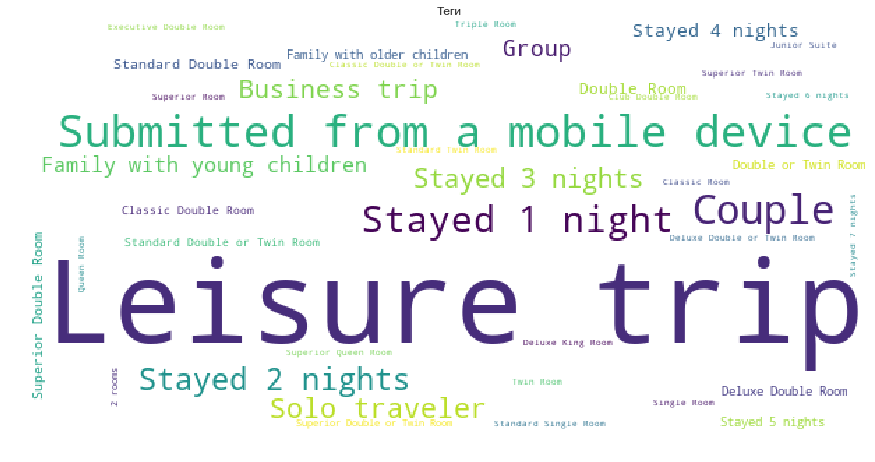

In [19]:
tags = []
for i in range(df.shape[0]):
    tags.extend(df["clean_tags"].values[i].split(', '))

wordcloud = WordCloud(**wc_params).generate_from_frequencies(Counter(tags))
plt.imshow(wordcloud)
plt.title("Теги")
plt.axis("off")
plt.show()

Что же, тут больше информации - можно будет вытащить инофрмацию о количестве дней, количестве человек (один/с семьей/группой) и тип путешествия - деловой/отпуск

Посмотрим, что по национальностями. Для этого найдем и построим график для топ 10 самых позитивных и негативных наций (возьмеем только те, что представлены более чем 100 представителями) - увидим, есть ли между различие.

In [20]:
df['Reviewer_Nationality'] = df['Reviewer_Nationality'].str.strip()

agg_data = df.groupby("Reviewer_Nationality")['Reviewer_Score'].agg(['mean','count'])
top_natons_reviews = agg_data[agg_data['count'] > 100]['mean'].sort_values()
top_natons_reviews = pd.concat((top_natons_reviews[:10], top_natons_reviews[-10:]))

(7, 9)

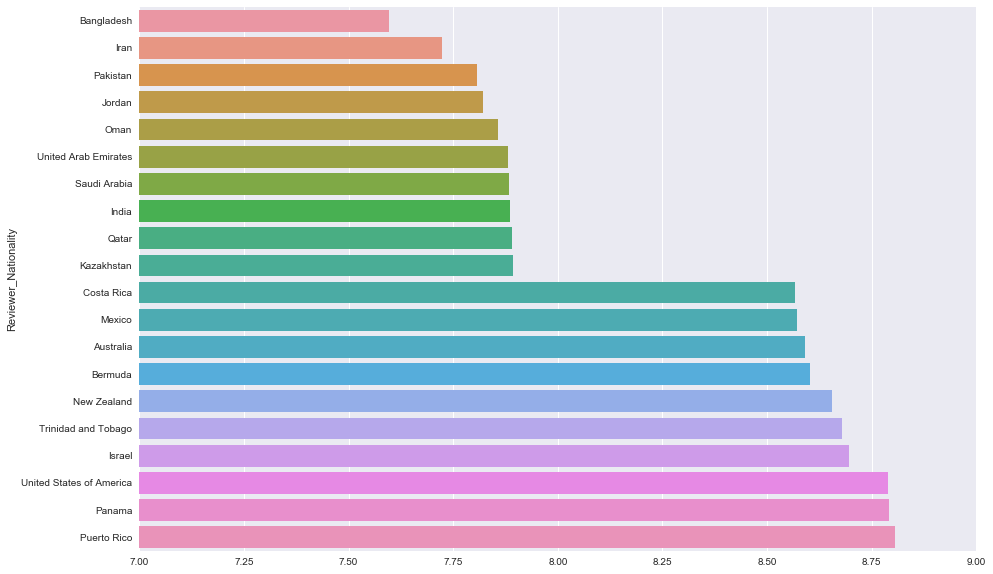

In [21]:
g = sns.barplot(y=top_natons_reviews.index,x=top_natons_reviews.values)
g.set_xlim(7,9)

Как видим, люди разной национальности оценивают отели по раному. Что характерно, ниже всего ставят оценки представители исламских стран, а самые высокие ставят люди из стран Нового света. Посмотрим для интереса отзывы людей из России

In [22]:
agg_data.loc['Russia']

mean        8.273517
count    3844.000000
Name: Russia, dtype: float64

Чуть меньше среднего в 8.4

Посмотрим, меняется ли средняя оценка с увеличением количества написанных отзывов? Как отмечось ранее, этот параметр распределен очень неравномерно, поэтому выделим тех кто написал больше 30 отзывов в одну же группу. Так и график будет лучше читаться, и для построения модели мы избавимся от выбросов. В целом же логично выделить тех кто очень много пишет в отдельную группу - неважно, человек написал 50 или 100 отзывов - все равно эти два человека больше похожи друг на друга этим параметром, чем на остальную массу людей

(7, 9)

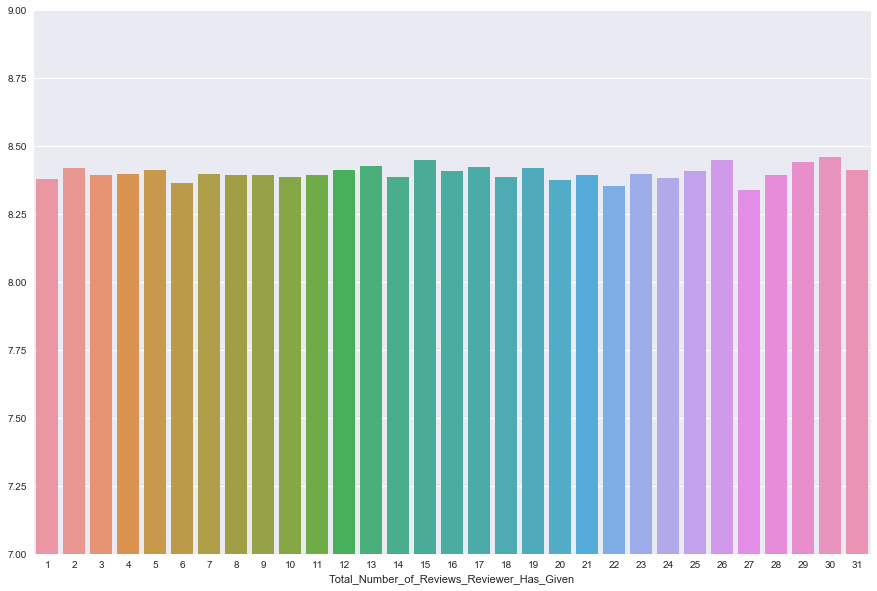

In [23]:
reviews = df[["Total_Number_of_Reviews_Reviewer_Has_Given", 'Reviewer_Score']]
reviews['Total_Number_of_Reviews_Reviewer_Has_Given'][reviews["Total_Number_of_Reviews_Reviewer_Has_Given"]  > 30] = 31
agg_data = reviews.groupby("Total_Number_of_Reviews_Reviewer_Has_Given")['Reviewer_Score'].mean().sort_index()
g = sns.barplot(x=agg_data.index,y=agg_data.values)
g.set_ylim(7,9)

Никакой зависимости не видно. Посмотрим, что получится из количества слов в положительных и отрицательных отзывах

(6, 10)

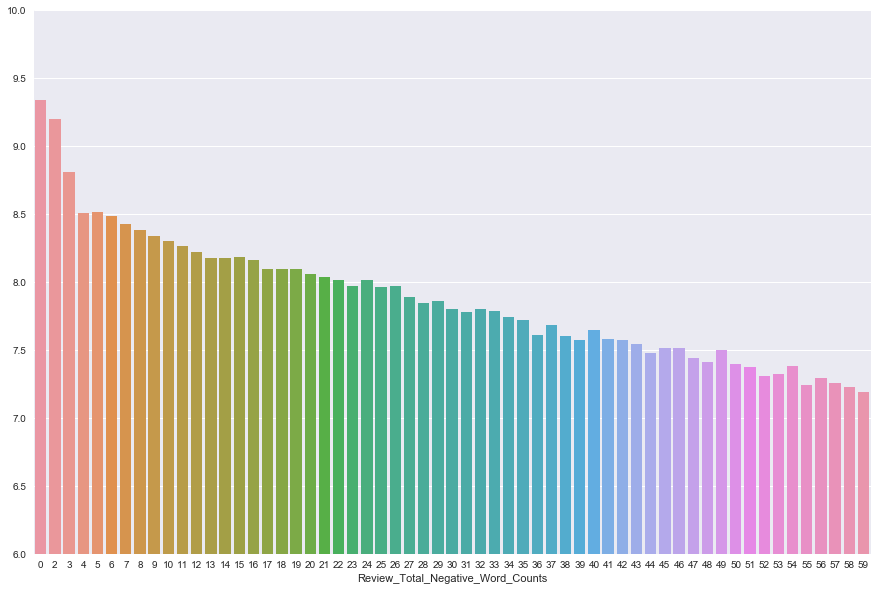

In [24]:
agg_data = df.groupby("Review_Total_Negative_Word_Counts")['Reviewer_Score'].agg(['mean','count'])
top_natons_reviews = agg_data[agg_data['count'] > 1000]['mean'].sort_index()
g = sns.barplot(x=top_natons_reviews.index,y=top_natons_reviews.values)
g.set_ylim(6,10)

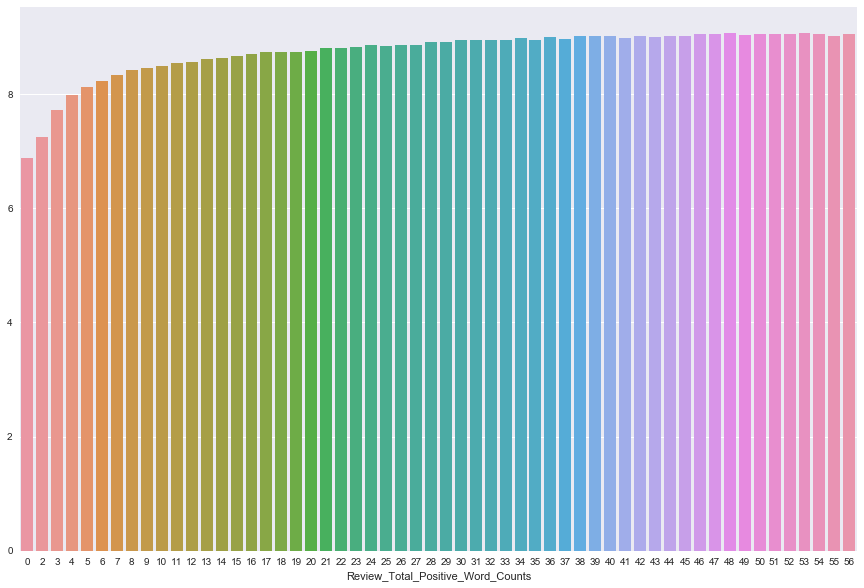

In [25]:
agg_data = df.groupby("Review_Total_Positive_Word_Counts")['Reviewer_Score'].agg(['mean','count'])
top_natons_reviews = agg_data[agg_data['count'] > 1000]['mean'].sort_index()
g = sns.barplot(x=top_natons_reviews.index,y=top_natons_reviews.values)

А тут уже очень хорошо видно зависимость - чем меньше негативных слов, тем выше оценка - и наоборот. Причем ля негативных отзывов связь особенно сильная.

###  Часть 4. Закономерности, "инсайты", особенности данных

Подытожим найденные закономерности. Во первых, датасет практически без пропусков и больших выбросов. Сильных корреляций признаков между собой нет, что хорошо - это означает независимую природу данных. Единственно исключение - количество отзывов и оценок без отзывов сильно коррелируют между собой, т.к они обе по сути завязаны на популярность. Зависимость оценки от многих переменных сильно скошена в одну из сторон - что в принципе логично, когда человек оставляет отзыв он как правило либо доволен, либо не доволен, и эмоции сильно сдвигают оценку вниз или вверх. Был найден слабый тренд по месяцам, так что будем использовать номер месяца как признак для построения модели. Так же найдена зависимость между национальностью и оценкой, что тоже объяснимо - люди из разных культур по разном смотрят на мир. Именно из культур, а не конкретных стран (хотя от конкретной страны тоже многое зависит)- топ 10 по положительным и отрицательным оценкам можно легко разбить на две логичные группы, например. Самая хорошая зависимость была найдена между количеством слов  - негативных и положительных - и общей оценкой. Причем инересно, насколько сильно отсутсвие негативных слов влияет на оценку - видимо, тот, кто едет отдыхать, по умолчанию готов поставить отелю высший бал - главное ничего не испортить. Корелляция между целевой переменной и положительными отзывами думаю и так понятна. Так же много информации содержится в тегах - если ее извлечь, можно сформировать множество признаков.


###  Часть 5. Выбор метрики

Так как у нас задача регрессии, то основными метриками будет средняя абсолютная ошибка и среднеквадратичная ошибка. Так у нас целевая переменная сильно скошена, то будем использовать MAE. При этом среднюю абсолютную ошибку в какой то степени проще интерпретировать - легче будет сравнить с бейзлайном (безлайном можем считать среднюю оценку отеля)

###  Часть 6. Выбор модели 

В качестве первой модели, попробуем линейную модель - так как у нас много информации содержится в тексктовых полях (негативный\позитивный отзыв, теги, название отеля) то после преобразования мы получим много разреженных матриц. Решающие деревья\леса скорее всего плохо зайдут на таких данных. Основные модели для линейной регрессии - Ridge и Lasso. Проверим, какая из них покажет лучший результат.

###  Часть 7. Предобработка данных 

Начнем предобработку данных. Выделим целевую переменную, сформируем holdout выборку. Так как у нас данные упорядоченны во времени, тренировать мы будем на старых данных, а предсказывать на новых. Отложим примерно 20% - так, чтобы в трейне было 400000 наблюдений. Уберем целевую переменную и 'Additional_Number_of_Scoring' из списка числовых столбцов - они не понядобятся нам для построения модели. Random seed был зафиксирован изначально, так что можно его не задавать для каждой отдельной операции

In [27]:
def split_to_holdout(df, index=400000):
    y = df['Reviewer_Score']
    X = df.drop(['Reviewer_Score'], axis=1)
    return X.iloc[:index], X.iloc[index:], y.iloc[:index], y.iloc[index:]

numeric_cols_linear = list(set(numeric_cols) - set(('Reviewer_Score','Additional_Number_of_Scoring')))
X, X_hold, y, y_hold = split_to_holdout(df)

Отмасштабируем числовые признаки, применим CountVectorizer к текстовым, закодируем OHE национальность и месяц. Национальность при этом сначала преобразуем при помощи LabelEncoder. 

In [28]:
sc = StandardScaler()
X_scaled = sc.fit_transform(X[numeric_cols_linear])
X_hold_scaled = sc.transform(X_hold[numeric_cols_linear])

In [29]:
X_counts = {}
X_hold_counts = {}
for col in ['Hotel_Address', 'Hotel_Name', 'Negative_Review', 'Positive_Review', 'clean_tags']:
    cv = CountVectorizer(max_features=50000, ngram_range=(1,2))
    X_counts[col] = cv.fit_transform(X[col])
    X_hold_counts[col] = cv.transform(X_hold[col])

In [30]:
le = LabelEncoder()
le.fit(df['Reviewer_Nationality'])
X['reviewer'] = le.transform(X['Reviewer_Nationality'])
X_hold['reviewer'] = le.transform(X_hold['Reviewer_Nationality'])

In [31]:
ohe = OneHotEncoder()
X_ohe = ohe.fit_transform(X[['month', 'reviewer']])
X_hold_ohe = ohe.transform(X_hold[['month', 'reviewer']])

Соберем признаки в один массив

In [36]:
X_train = hstack([hstack(list(X_counts.values())), X_ohe, X_scaled])
X_test = hstack([hstack(list(X_hold_counts.values())), X_hold_ohe, X_hold_scaled])

Посмотрим, что смогут сделать линейные модели без настройки гиперпараметров

In [33]:
ridge = Ridge(random_state=42)
ridge.fit(X_train, y)
ridge_pred = ridge.predict(X_test)
ridge_error = mean_absolute_error(y_hold, ridge_pred)

In [34]:
lasso = Lasso(random_state=42)
lasso.fit(X_train, y)
lasso_pred = lasso.predict(X_test)
lasso_error = mean_absolute_error(y_hold, lasso_pred)

In [35]:
print(ridge_error)
print(lasso_error)

0.8826733487745574
1.3434500158833602


Сравним это с бейзлайном - предсказывать в качестве оценки среднюю оценку отеля

In [38]:
average_error = mean_absolute_error(y_hold, X_hold['Average_Score'])
print('average_error - {}'.format(average_error))
print('relative_lasso_error - {}'.format(ridge_error/average_error))
print('relative_ridge_error - {}'.format(lasso_error/average_error))

average_error - 1.2185507246376812
relative_lasso_error - 0.7243632381713184
relative_ridge_error - 1.1024982290194083


Между Lasso и Ridge оказалась большая разница - Lasso даже не смогла побить наш простейший бейзлайн. Ridge же вполне смогла улучшить качество предсказания, даже без настройки гиперпараметров. Можно было бы продолжить улучшать эти модели, но на самом деле есть одна проблема. Изначально мы хотели сделать рекомендательный сервис, а в тех данных что у нас есть - лик. Мы уже знаем, что написал пользователь в отзыве (как положительном, так и отрицательном) - но такой информации перед бронированием отеля у нас не будет. Поэтому отбросим признаки, связанные с отзывами - и попробуем новую модель. Без эти признаков у нас уже будет не такие разреженные данные, общее количество признаков будет небольшим, данные разнородные (как категориональные, так и количественные). Можно догадаться, что я собираюсь применять в такой ситуации - градиентный бустинг над решающими деревьями. Лично я решил попробовать в этой задаче lightGBM. Для lightGBM-модели мы поменяем предобработку признаков, а так же выделим новые признаки - иначе без отзывов мы не получим хороший результат, так как останется слишком мало параметров.

###  Часть 8. Создание новых признаков и описание этого процесса

Начнем с выделения данных из тегов. Выделим тип поездки (по делу или на отдых), каким составом поедет пользователь (один, с семьей и т.д) а так же на сколько дней планирует оставаться. Если в теге нет нужной информации, то мы ставим -1: отрицательные значения в категориональных признаках свидельствуют о пропуске в даннных (в реализации lightGBM)

In [39]:
def find_type(x):
    if 'leisure' in x['clean_tags'].lower():
        return 1
    if 'business' in x['clean_tags'].lower():
        return 0
    return -1

df["type"] = df.apply(func=find_type, axis=1)

In [40]:
def find_group(x):
    if 'solo' in x['clean_tags'].lower():
        return 1
    if 'couple' in x['clean_tags'].lower():
        return 2
    if 'family' in x['clean_tags'].lower():
        return 3
    if 'group' in x['clean_tags'].lower():
        return 0
    return -1

df["group"] = df.apply(func=find_group, axis=1)

In [41]:
def find_days(x):
    if 'stayed' in x['clean_tags'].lower():
        tags =  x['clean_tags'].lower().split(', ')
        for tag in tags:
            if 'stayed' in tag:
                try:
                    res = int(re.sub("\D", "", tag))
                except ValueError:
                    res = -1
                return res
    return -1

df["days"] = df.apply(func=find_days, axis=1)

Так же выделим страну, в которой находится отель из адреса.

In [42]:
df['hotel_country'] = df["Hotel_Address"].apply(lambda x: x.split()[-1])

###  Часть 9. Кросс-валидация, подбор параметров

Сфоррмируем выборки еще раз.

In [43]:
X, X_hold, y, y_hold = split_to_holdout(df)

Так как мы будем проводить кросс-валидацию и поиск гиперпараметров - неплохо было бы объединить эти действия в одно. Для этого будем использовать GridSearchCV. Масштабировать признаки не будем - в целом, деревьям решений нет дела до масштаба. One-hot encoding тоже не нужен, будем делать только преобразование категориональных признаков из текста в числа - lightGBM работает лучше без OHE. Разбивать выбоку для кросс-валидации будем как и раньше, при помощи TimeSeriesSplit.

In [44]:
le = LabelEncoder()
le.fit(df['Reviewer_Nationality'])
X['nation'] = le.transform(X['Reviewer_Nationality'])
X_hold['nation'] = le.transform(X_hold['Reviewer_Nationality'])
X['country'] = le.fit_transform(X['hotel_country'])
X_hold['country'] = le.transform(X_hold['hotel_country'])
categorical_cols = ['nation','month','country', 'days', 'type', 'group']

In [45]:
numeric_cols_tree = list(set(numeric_cols_linear) - set(('Review_Total_Positive_Word_Counts','Review_Total_Negative_Word_Counts')))

In [46]:
X_train = X[categorical_cols + numeric_cols_tree]

In [47]:
X_test = X_hold[categorical_cols + numeric_cols_tree]

In [48]:
tss = TimeSeriesSplit(n_splits=5)

Тюнить мы будем стандартные гиперпараметры. learning_rate - это скорость обучения, по дефолту равна 0.1 - возьмем чуть меньше и чуть больше, num_iterations - так называется n_estimators в LGBM, это количество построенных деревьев. Дефолтное значение - 100, мы возьмем чуть меньше и намного больше - учитывая количество данных, большое число вполне может быть оправданным. Ну и num_leaves - это аналог параметра max_depth (такой, что num_leaves = 2^(max_depth)). В LGBM используется другой алгоритм построения дерева - leaf-wise вместо max_depth (по сравнению с другими библиотеками, тем же XGBoost). По умолчанию значение 31, мы попробуем еще 15 и 63.

In [49]:
grid = {
        'learning_rate': [.05,.1,.2],
    'num_iterations': [40, 100, 500, 1000],
    'num_leaves': [15,31,63]
    }
clf = lgb.LGBMRegressor(application='neg_mean_absolute_error', categorical_feature=list(range(len(categorical_cols))))
gs = GridSearchCV(clf, grid, cv=tss, verbose=2, scoring='neg_mean_absolute_error')

In [50]:
gs.fit(X_train, y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] num_leaves=15, learning_rate=0.05, num_iterations=40 ............
[CV]  num_leaves=15, learning_rate=0.05, num_iterations=40, total=   0.5s
[CV] num_leaves=15, learning_rate=0.05, num_iterations=40 ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  num_leaves=15, learning_rate=0.05, num_iterations=40, total=   0.6s
[CV] num_leaves=15, learning_rate=0.05, num_iterations=40 ............
[CV]  num_leaves=15, learning_rate=0.05, num_iterations=40, total=   0.8s
[CV] num_leaves=15, learning_rate=0.05, num_iterations=40 ............
[CV]  num_leaves=15, learning_rate=0.05, num_iterations=40, total=   0.9s
[CV] num_leaves=15, learning_rate=0.05, num_iterations=40 ............
[CV]  num_leaves=15, learning_rate=0.05, num_iterations=40, total=   1.2s
[CV] num_leaves=31, learning_rate=0.05, num_iterations=40 ............
[CV]  num_leaves=31, learning_rate=0.05, num_iterations=40, total=   0.5s
[CV] num_leaves=31, learning_rate=0.05, num_iterations=40 ............
[CV]  num_leaves=31, learning_rate=0.05, num_iterations=40, total=   0.6s
[CV] num_leaves=31, learning_rate=0.05, num_iterations=40 ............
[CV]  num_leaves=31, learning_rate=0.05, num_iterations=40, total=   0.9s
[CV] num_leaves=31, learning_rate=0.05, num_iterations=4

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 27.0min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=LGBMRegressor(application='neg_mean_absolute_error', boosting_type='gbdt',
       categorical_feature=[0, 1, 2, 3, 4, 5], class_weight=None,
       colsample_bytree=1.0, learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'num_leaves': [15, 31, 63], 'learning_rate': [0.05, 0.1, 0.2], 'num_iterations': [40, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=2)

In [55]:
print(gs.best_params_)
print(gs.best_score_)

{'num_leaves': 15, 'learning_rate': 0.1, 'num_iterations': 100}
-1.15623286872393


Как видно, learning_rate и num_iterations лучше работают если их оставить как есть, num_leaves в нашем случае можно уменьшить - у нас мало признаков, поэтому слишком сожная модель тут не нужна. При этом видно, что уменьшив количество признаков мы сильно ухудшили качество модели - теперь она с трудом бьет бейзлайн

###  Часть 10. Построение кривых валидации и обучения 

Построим кривые для валидации и обучения. Возьмем для построения функцию из туториалов на scikit-learn.org, и посмотрим как ведет себя наша модель на обучении.

In [52]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    '''
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    '''
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_absolute_error')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [53]:
model = lgb.LGBMRegressor(**gs.best_params_, categorical_feature=list(range(len(categorical_cols))))

<Figure size 1080x720 with 0 Axes>

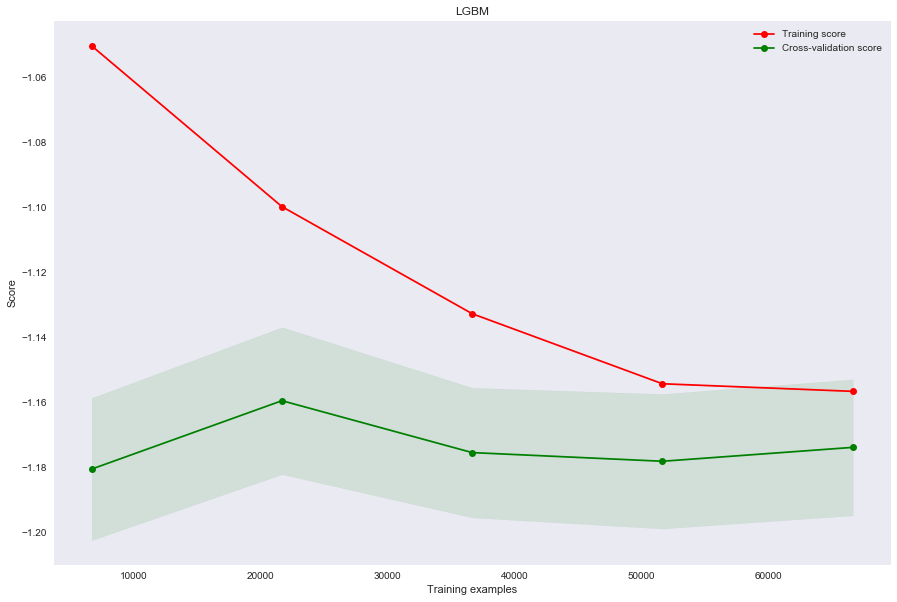

<Figure size 1080x720 with 0 Axes>

In [54]:
plot_learning_curve(model, 'LGBM', X_train, y, cv=tss);
plt.figure(figsize=(15, 10))

На графике видно, что ошибка на валидации практически не уменьшается во время тренировки, только в самом начале, а затем даже начинает расти (ошибка не трейне ведет себя стандартно). Это говорит о небольшом переобучении - хотя в дальнейшем график выходит на плато. Причина в том, что у нас не хватило данных для анализа, после того как мы убрали все переменные связанные с отзывами пользователя. Алгоритм не может построить хорошее предсказание на имеющихся данных.

###  Часть 11. Прогноз для отложенной выборки, оценка модели с описанием выбранной метрики

Как видно, наша модель совсем чуть-лучше бейзлайна. Это произошло потому, что мы исключили  самые важные признаки - проверим, улучшится ли модель если мы добавим количество слов в отзыве в параметры. В принципе, то же самое мы получили и на кросс-валидации

In [66]:
X_train_leaked = X[categorical_cols + numeric_cols_linear]
X_test_leaked = X_hold[categorical_cols + numeric_cols_linear]
model_leaked = lgb.LGBMRegressor(**gs.best_params_, categorical_feature=list(range(len(categorical_cols))))
model_leaked.fit(X_train_leaked, y)
y_leaked = model_leaked.predict(X_test_leaked)
print(mean_absolute_error(y_leaked, y_hold))

0.9334705738292058


Как видим, мы почти смогли повторить показатели линейной модели. При этом надо понимать, что просто количество слов менее хороший параметр чем сам текст отзыва - например, положительный отзыв "No positive" и "Everything fine" содержат по два слова, но являются прямо противоположными по смыслу.

### Часть 12. Выводы 

Итак, насколько же меньше ошибок совершает наша модель, по сравнению со средним значением рейтинга отеля?

In [68]:
print(mean_absolute_error(y_hold, X_hold['Average_Score']) /  mean_absolute_error(y_pred, y_hold))
print(mean_absolute_error(y_hold, X_hold['Average_Score']) /  mean_absolute_error(y_leaked, y_hold))

1.0263106859594688
1.3053981119501636


Итак, у нас не получилось натренировать модель, которая дает среднюю абсолютную ошибку значитльно меньше, чем если бы мы просто предсказывали среднюю оценку. Это значит, что конечный пользователь не сможет использовать получившуюся модель для того, чтобы облегчить свой выбор. В то же время, если бы задача стояла в предсказании оценки на основе отзыва - то тут ошибка падает на 30% по сравнению с бейзлайном, даже без использования текста отзыва. Но надо понимать, что такая задача наврядли может возникнуть в реальном мире, потому что раз уж у нас есть отзывы, то и оценка наверняка будет.  
Чтобы модель заработала, нужно вводить дополнительны параметры - например, в зависимости от цены. В негативных отзывах были видны жалобы на дороговизну, так что учитывать благосостояние было бы логичным шагом. Ну и не только, ведь по сути у нас было очень мало данных связанных с личностью пользователя - если этот набор расширить, то можно заметно улучшить качество модели. Т.е можно попытаться проанализировать негативные и отрицательные отзывы, выделить самые частые и предоставить мини-анкету, чтобы понять предпочтени пользователя - и делать прогноз на их основе.  
В любом случае, данный проект показывает важность данных в data science - если у нас данные, которые не имеют хорошей связи с целевой переменной, то какие бы продвинутые методы мы не использовали - ничего не выйдет. Правило Garbage In - Gabage Out никто не отменял.